# Import Packages

In [6]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, InputLayer
from keras.optimizers import SGD, Adam, RMSprop
from keras.activations import relu, elu, sigmoid
from keras.regularizers import l1, l2
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.ndimage import rotate


# Data Visualisation

In [115]:
train_data = pd.read_csv('emnist-balanced-train.csv', header=None)
test_data = pd.read_csv('emnist-balanced-test.csv', header=None)


In [116]:
sns.set()


Displaying number of training and testing data

In [117]:
training_samples = train_data.shape[0]
testing_samples = test_data.shape[0]


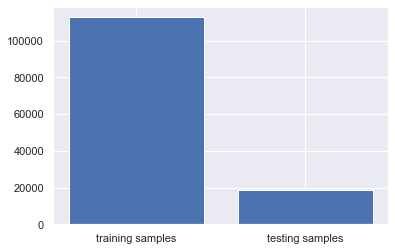

In [118]:
bar_chart = plt.bar(['training samples', 'testing samples'], [
                    training_samples, testing_samples])


### Displaying some train samples

In [119]:
mappings = pd.read_csv('emnist-balanced-mapping.txt',
                       header=None, sep=' ').to_numpy()


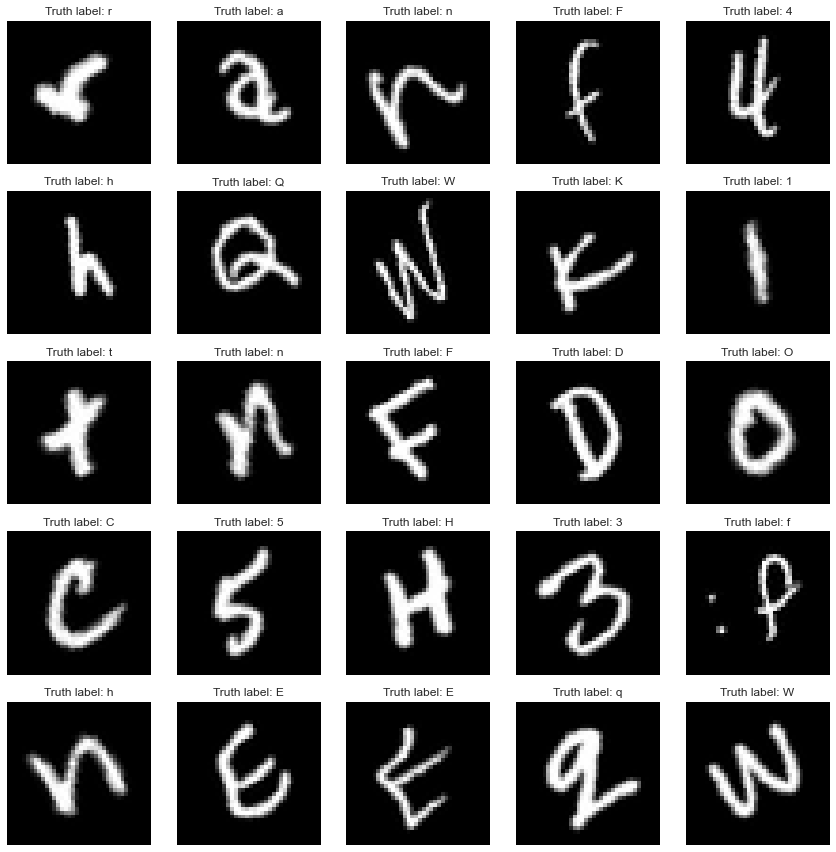

In [120]:
n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True,
                        sharey=True, figsize=(12, 12))
for i in range(n**2):

    sample = train_data.iloc[i]
    # get label of sample
    sample_label = sample[0]
    sample_label = chr(mappings[sample_label][1])

    pixels = sample[1:].to_numpy(dtype='uint8')
    pixels = pixels.reshape((28, 28))
    pixels = rotate(pixels, angle=240, reshape=True)

    ax = axs[i // n, i % n]
    ax.title.set_text(f'Truth label: {sample_label}')
    ax.imshow(np.fliplr(pixels), cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
plt.show()


#### Data extraction and preprocessing

In [129]:
X_train_full, y_train_full = train_data.iloc[:, 1:].to_numpy(
), train_data.iloc[:, 0].to_numpy()

X_valid, X_train = X_train_full[:5000].reshape(
    -1, 28, 28, 1)/255.0, X_train_full.reshape(-1, 28, 28, 1)[5000:]/255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
y_train = keras.utils.to_categorical(y_train)
y_valid = keras.utils.to_categorical(y_valid)


# Convolution Neural Network (CNN)

CNN model with 2 Convolution layers

In [9]:
# CNN model with parameters as arguments
def create_model(learning_rate=0.01, activation='relu', optimizer=Adam, batch_norm=False, l1_reg=0.0, l2_reg=0.0, dropout=False, scheduler=None):
    model = keras.Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation, input_shape=(
        28, 28, 1), kernel_regularizer=l1(l1_reg), bias_regularizer=l2(l2_reg)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Conv2D(64, (3, 3), activation=activation,
              kernel_regularizer=l1(l1_reg), bias_regularizer=l2(l2_reg)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25)) if dropout else None
    model.add(Flatten())
    model.add(Dense(128, activation=activation, kernel_regularizer=l1(
        l1_reg), bias_regularizer=l2(l2_reg)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(0.5)) if dropout else None
    model.add(Dense(47, activation='softmax'))
    if scheduler == 'step':
        lr_scheduler = LearningRateScheduler(
            lambda epoch: learning_rate * 0.1 ** epoch)

       
    elif scheduler == 'exp':
        lr_scheduler = LearningRateScheduler(
            lambda epoch: learning_rate * np.exp(-epoch / 10))

     

    optimiser = optimizer(learning_rate=learning_rate)
    model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [10]:
# Function to perform grid search validation
def Grid_Search(params, model):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=3, verbose=2)
    grid_result = grid.fit(X_train, y_train)
    return grid_result.best_score_, grid_result.best_params_


# Parameter Tuning

### 1: Select the best Learning rate Scheduler

In [11]:
param_learn = {
    'scheduler': ['step', 'exp']
}
model = KerasClassifier(build_fn=create_model, epochs=5,
                        batch_size=32, verbose=2)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10232\983864372.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=2)


In [12]:
grid_result_learn_score, grid_result_learn_param = Grid_Search(
    param_learn, model)

# Print the results
print("Best: %f using %s" % (grid_result_learn_score, grid_result_learn_param))


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/5
2246/2246 - 31s - loss: 0.7741 - accuracy: 0.7525 - 31s/epoch - 14ms/step
Epoch 2/5
2246/2246 - 31s - loss: 0.5658 - accuracy: 0.8094 - 31s/epoch - 14ms/step
Epoch 3/5
2246/2246 - 31s - loss: 0.5339 - accuracy: 0.8173 - 31s/epoch - 14ms/step
Epoch 4/5
2246/2246 - 26s - loss: 0.5196 - accuracy: 0.8225 - 26s/epoch - 12ms/step
Epoch 5/5
2246/2246 - 26s - loss: 0.5055 - accuracy: 0.8268 - 26s/epoch - 12ms/step
1123/1123 - 6s - loss: 0.5952 - accuracy: 0.8093 - 6s/epoch - 5ms/step
[CV] END .....................................scheduler=step; total time= 2.5min
Epoch 1/5
2246/2246 - 28s - loss: 0.8219 - accuracy: 0.7384 - 28s/epoch - 13ms/step
Epoch 2/5
2246/2246 - 28s - loss: 0.6028 - accuracy: 0.7978 - 28s/epoch - 12ms/step
Epoch 3/5
2246/2246 - 28s - loss: 0.5782 - accuracy: 0.8043 - 28s/epoch - 12ms/step
Epoch 4/5
2246/2246 - 28s - loss: 0.5647 - accuracy: 0.8082 - 28s/epoch - 12ms/step
Epoch 5/5
2246/2246 - 26s - loss:

### 2: Select the best optimizer

In [13]:
param_opt = {
    'scheduler': [grid_result_learn_param['scheduler']],
    'optimizer': [SGD, Adam, RMSprop]
}
model_1 = KerasClassifier(build_fn=create_model,
                          epochs=5, batch_size=32, verbose=2)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10232\2151797180.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_1 = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=2)


In [14]:
grid_result_opt_score, grid_result_opt_param = Grid_Search(param_opt, model_1)

# Print the results
print("Best: %f using %s" % (grid_result_opt_score, grid_result_opt_param))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/5
2246/2246 - 25s - loss: 1.8688 - accuracy: 0.4891 - 25s/epoch - 11ms/step
Epoch 2/5
2246/2246 - 23s - loss: 0.7728 - accuracy: 0.7566 - 23s/epoch - 10ms/step
Epoch 3/5
2246/2246 - 23s - loss: 0.6041 - accuracy: 0.8015 - 23s/epoch - 10ms/step
Epoch 4/5
2246/2246 - 23s - loss: 0.5341 - accuracy: 0.8218 - 23s/epoch - 10ms/step
Epoch 5/5
2246/2246 - 23s - loss: 0.4883 - accuracy: 0.8346 - 23s/epoch - 10ms/step
1123/1123 - 5s - loss: 0.5433 - accuracy: 0.8179 - 5s/epoch - 4ms/step
[CV] END optimizer=<class 'keras.optimizers.legacy.gradient_descent.SGD'>, scheduler=step; total time= 2.0min
Epoch 1/5
2246/2246 - 23s - loss: 1.9157 - accuracy: 0.4776 - 23s/epoch - 10ms/step
Epoch 2/5
2246/2246 - 23s - loss: 0.7900 - accuracy: 0.7508 - 23s/epoch - 10ms/step
Epoch 3/5
2246/2246 - 24s - loss: 0.6038 - accuracy: 0.8020 - 24s/epoch - 11ms/step
Epoch 4/5
2246/2246 - 24s - loss: 0.5257 - accuracy: 0.8246 - 24s/epoch - 11ms/step
Epoc

### 3: Select the best activation function

In [15]:
param_act = {
    'scheduler': [grid_result_learn_param['scheduler']],
    'optimizer': [grid_result_opt_param['optimizer']],
    'activation': ['relu', 'elu', 'sigmoid']
}
model_2 = KerasClassifier(build_fn=create_model,
                          epochs=5, batch_size=32, verbose=2)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10232\2227029905.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_2 = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=2)


In [16]:
grid_result_act_score, grid_result_act_param = Grid_Search(param_act, model_2)

# Print the results
print("Best: %f using %s" % (grid_result_act_score, grid_result_act_param))


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/5
2246/2246 - 31s - loss: 1.9472 - accuracy: 0.4726 - 31s/epoch - 14ms/step
Epoch 2/5
2246/2246 - 27s - loss: 0.7951 - accuracy: 0.7528 - 27s/epoch - 12ms/step
Epoch 3/5
2246/2246 - 26s - loss: 0.6205 - accuracy: 0.7987 - 26s/epoch - 12ms/step
Epoch 4/5
2246/2246 - 27s - loss: 0.5433 - accuracy: 0.8197 - 27s/epoch - 12ms/step
Epoch 5/5
2246/2246 - 29s - loss: 0.4952 - accuracy: 0.8330 - 29s/epoch - 13ms/step
1123/1123 - 6s - loss: 0.5403 - accuracy: 0.8205 - 6s/epoch - 5ms/step
[CV] END activation=relu, optimizer=<class 'keras.optimizers.legacy.gradient_descent.SGD'>, scheduler=step; total time= 2.5min
Epoch 1/5
2246/2246 - 27s - loss: 1.8042 - accuracy: 0.5022 - 27s/epoch - 12ms/step
Epoch 2/5
2246/2246 - 26s - loss: 0.7825 - accuracy: 0.7570 - 26s/epoch - 12ms/step
Epoch 3/5
2246/2246 - 30s - loss: 0.6112 - accuracy: 0.8028 - 30s/epoch - 14ms/step
Epoch 4/5
2246/2246 - 27s - loss: 0.5366 - accuracy: 0.8224 - 27s/epoch

### 4: Deciding whether batch normalisation and dropout is required

In [17]:
params = {
    'scheduler': [grid_result_learn_param['scheduler']],
    'optimizer': [grid_result_opt_param['optimizer']],
    'activation': [grid_result_act_param['activation']],
    'batch_norm': [True, False],
    'dropout': [True, False]
}
model_3 = KerasClassifier(build_fn=create_model,
                          epochs=5, batch_size=32, verbose=2)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10232\684361155.py:8: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_3 = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=2)


In [18]:
grid_result_b_score, grid_result_b_param = Grid_Search(params, model_3)

# Print the results
print("Best: %f using %s" % (grid_result_b_score, grid_result_b_param))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/5
2246/2246 - 39s - loss: 1.5803 - accuracy: 0.5547 - 39s/epoch - 18ms/step
Epoch 2/5
2246/2246 - 37s - loss: 0.8877 - accuracy: 0.7259 - 37s/epoch - 16ms/step
Epoch 3/5
2246/2246 - 42s - loss: 0.7559 - accuracy: 0.7622 - 42s/epoch - 19ms/step
Epoch 4/5
2246/2246 - 42s - loss: 0.6962 - accuracy: 0.7771 - 42s/epoch - 19ms/step
Epoch 5/5
2246/2246 - 42s - loss: 0.6472 - accuracy: 0.7907 - 42s/epoch - 19ms/step
1123/1123 - 9s - loss: 0.4723 - accuracy: 0.8440 - 9s/epoch - 8ms/step
[CV] END activation=elu, batch_norm=True, dropout=True, optimizer=<class 'keras.optimizers.legacy.gradient_descent.SGD'>, scheduler=step; total time= 3.5min
Epoch 1/5
2246/2246 - 44s - loss: 1.5846 - accuracy: 0.5530 - 44s/epoch - 20ms/step
Epoch 2/5
2246/2246 - 44s - loss: 0.8948 - accuracy: 0.7243 - 44s/epoch - 19ms/step
Epoch 3/5
2246/2246 - 43s - loss: 0.7632 - accuracy: 0.7594 - 43s/epoch - 19ms/step
Epoch 4/5
2246/2246 - 44s - loss: 0.6946

### 5: Selecting best values for l1 and l2 regularisation

In [19]:
param_reg = {
    'scheduler': [grid_result_learn_param['scheduler']],
    'optimizer': [grid_result_opt_param['optimizer']],
    'activation': [grid_result_act_param['activation']],
    'batch_norm': [grid_result_b_param['batch_norm']],
    'dropout': [grid_result_b_param['dropout']],
    'l1_reg': [0.0, 0.01],
    'l2_reg': [0.0, 0.01]
}
model_4 = KerasClassifier(build_fn=create_model,
                          epochs=5, batch_size=32, verbose=2)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10232\1913645677.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_4 = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=2)


In [20]:
grid_result_reg_score, grid_result_reg_param = Grid_Search(param_reg, model_4)

# Print the results
print("Best: %f using %s" % (grid_result_reg_score, grid_result_reg_param))


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/5
2246/2246 - 47s - loss: 0.9911 - accuracy: 0.7243 - 47s/epoch - 21ms/step
Epoch 2/5
2246/2246 - 42s - loss: 0.5525 - accuracy: 0.8266 - 42s/epoch - 19ms/step
Epoch 3/5
2246/2246 - 41s - loss: 0.4697 - accuracy: 0.8480 - 41s/epoch - 18ms/step
Epoch 4/5
2246/2246 - 40s - loss: 0.4263 - accuracy: 0.8601 - 40s/epoch - 18ms/step
Epoch 5/5
2246/2246 - 40s - loss: 0.3975 - accuracy: 0.8670 - 40s/epoch - 18ms/step
1123/1123 - 8s - loss: 0.4132 - accuracy: 0.8626 - 8s/epoch - 7ms/step
[CV] END activation=elu, batch_norm=True, dropout=False, l1_reg=0.0, l2_reg=0.0, optimizer=<class 'keras.optimizers.legacy.gradient_descent.SGD'>, scheduler=step; total time= 3.6min
Epoch 1/5
2246/2246 - 41s - loss: 0.9764 - accuracy: 0.7264 - 41s/epoch - 18ms/step
Epoch 2/5
2246/2246 - 40s - loss: 0.5565 - accuracy: 0.8268 - 40s/epoch - 18ms/step
Epoch 3/5
2246/2246 - 40s - loss: 0.4774 - accuracy: 0.8458 - 40s/epoch - 18ms/step
Epoch 4/5
2246/

# Final CNN model with best parameters

In [21]:
best_model = create_model(learning_rate=0.01, activation=grid_result_act_param['activation'], optimizer=grid_result_opt_param['optimizer'], batch_norm=grid_result_b_param['batch_norm'],
                          l1_reg=grid_result_reg_param['l1_reg'], l2_reg=grid_result_reg_param['l2_reg'], dropout=grid_result_b_param['dropout'], scheduler=grid_result_learn_param['scheduler'])

best_model.summary()


Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_60 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_106 (MaxPooli  (None, 13, 13, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_107 (Conv2D)         (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_61 (Bat  (None, 11, 11, 64)       256       
 chNormalization)                                                
                                                     

# Train the model and plot accuracy and loss graphs

In [22]:

start_time = time.time()
history1 = best_model.fit(X_train, y_train, epochs=30,
                          validation_data=(X_valid, y_valid))
end_time = time.time()
total_time = end_time - start_time


Epoch 1/30
3369/3369 [==============================] - 63s 19ms/step - loss: 0.8483 - accuracy: 0.7580 - val_loss: 0.5181 - val_accuracy: 0.8332
Epoch 2/30
3369/3369 [==============================] - 60s 18ms/step - loss: 0.4986 - accuracy: 0.8406 - val_loss: 0.4458 - val_accuracy: 0.8526
Epoch 3/30
3369/3369 [==============================] - 61s 18ms/step - loss: 0.4344 - accuracy: 0.8572 - val_loss: 0.4139 - val_accuracy: 0.8634
Epoch 4/30
3369/3369 [==============================] - 61s 18ms/step - loss: 0.3988 - accuracy: 0.8659 - val_loss: 0.3901 - val_accuracy: 0.8708
Epoch 5/30
3369/3369 [==============================] - 60s 18ms/step - loss: 0.3707 - accuracy: 0.8748 - val_loss: 0.3819 - val_accuracy: 0.8716
Epoch 6/30
3369/3369 [==============================] - 60s 18ms/step - loss: 0.3523 - accuracy: 0.8778 - val_loss: 0.3705 - val_accuracy: 0.8740
Epoch 7/30
3369/3369 [==============================] - 61s 18ms/step - loss: 0.3341 - accuracy: 0.8844 - val_loss: 0.3721 -

In [32]:
print(f"Total training time: {total_time:.2f} seconds")


Total training time: 2019.81 seconds


In [23]:
best_model.save('my_CNN_model.h5')


### Accuracy/Loss graph CNN

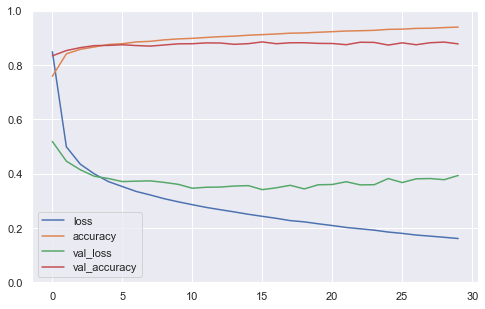

In [114]:

pd.DataFrame(history1.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()


# Testing the model with given test data

In [92]:
X_test_full, y_test_full = test_data.iloc[:, 1:].to_numpy(
), test_data.iloc[:, 0].to_numpy()
X_test = X_test_full.reshape(-1, 28, 28, 1)/255.0
y_test = keras.utils.to_categorical(y_test_full)

y_predict = best_model.predict(X_test)
# y_predict.round(2)


588/588 [==============================] - 7s 11ms/step


Finding the predicted output

In [93]:
classes_test = np.argmax(y_test, axis=1)
print(classes_test)


[41 39  9 ...  1 26 33]


Test labels

In [94]:
classes_x = np.argmax(y_predict, axis=1)
print(classes_x)


[41 39 44 ...  1 26 33]


## Prediction for top 6 samples in testing dataset with their images(CNN)

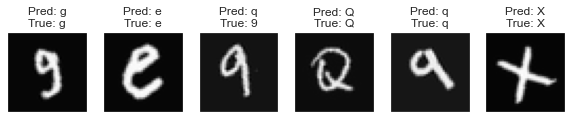

In [121]:

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 10), facecolor="white")
for i, ax in enumerate(axes.flat):
    # Display the image
    image = X_test[i]
    image = rotate(image, angle=240, reshape=True)
    ax.imshow(np.fliplr(image), cmap=plt.cm.gray)

    # Display the true label on top of the image

    ax.set_xticks([])
    ax.set_yticks([])

    # Display the predicted label on top of the true label
    ax.set_title(
        f"Pred: {chr(mappings[classes_x[i]][1])}\nTrue: {chr(mappings[classes_test[i]][1])}")
plt.show()


### Confusion Matrix

In [97]:
cm = confusion_matrix(classes_test[0:6], classes_x[0:6])


In [108]:
#Confusion matrix of first 6 samples
def plot_cm(y_test, classes_x,title):

    cm = confusion_matrix(y_test[0:6], classes_x[0:6])

    plt.figure(figsize=(10, 10))

    labels = y_test[0:6]
    labels = np.sort(labels)
    labels_main = []

    for i in range(6):
        labels_main.append(chr(mappings[labels[i]][1]))
    sns.heatmap(cm, edgecolor='black', linewidth=1, annot=True,
                cmap=plt.cm.Reds, xticklabels=(labels_main), yticklabels=(labels_main))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()


In [125]:
#Confusion matrix of whole predicted data
def plot_cm_47(y_test, classes_x,title):

    cm = confusion_matrix(y_test, classes_x)

    plt.figure(figsize=(20, 20))

    labels = classes_x
    labels = np.sort(labels)
    labels_main = np.arange(47)

    label_final = []

    for label in labels_main:
        label_final.append(chr(mappings[label][1]))

    sns.heatmap(cm, edgecolor='black', linewidth=1, annot=True,
                cmap=plt.cm.Reds, xticklabels=(label_final), yticklabels=(label_final))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()



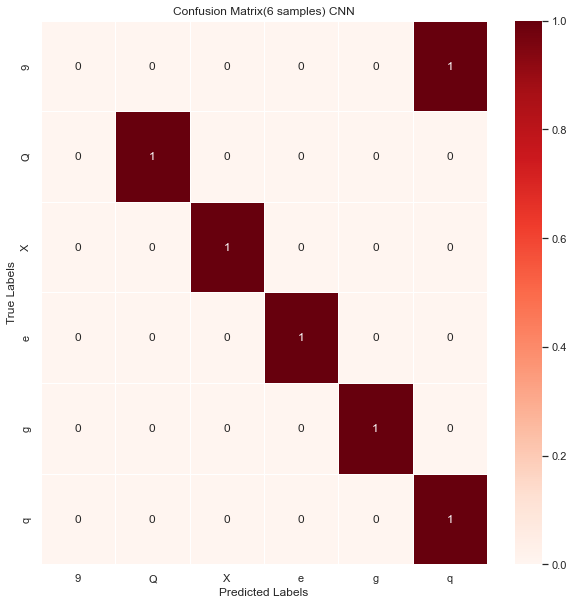

In [109]:
plot_cm(classes_test,classes_x,'Confusion Matrix(6 samples) CNN')

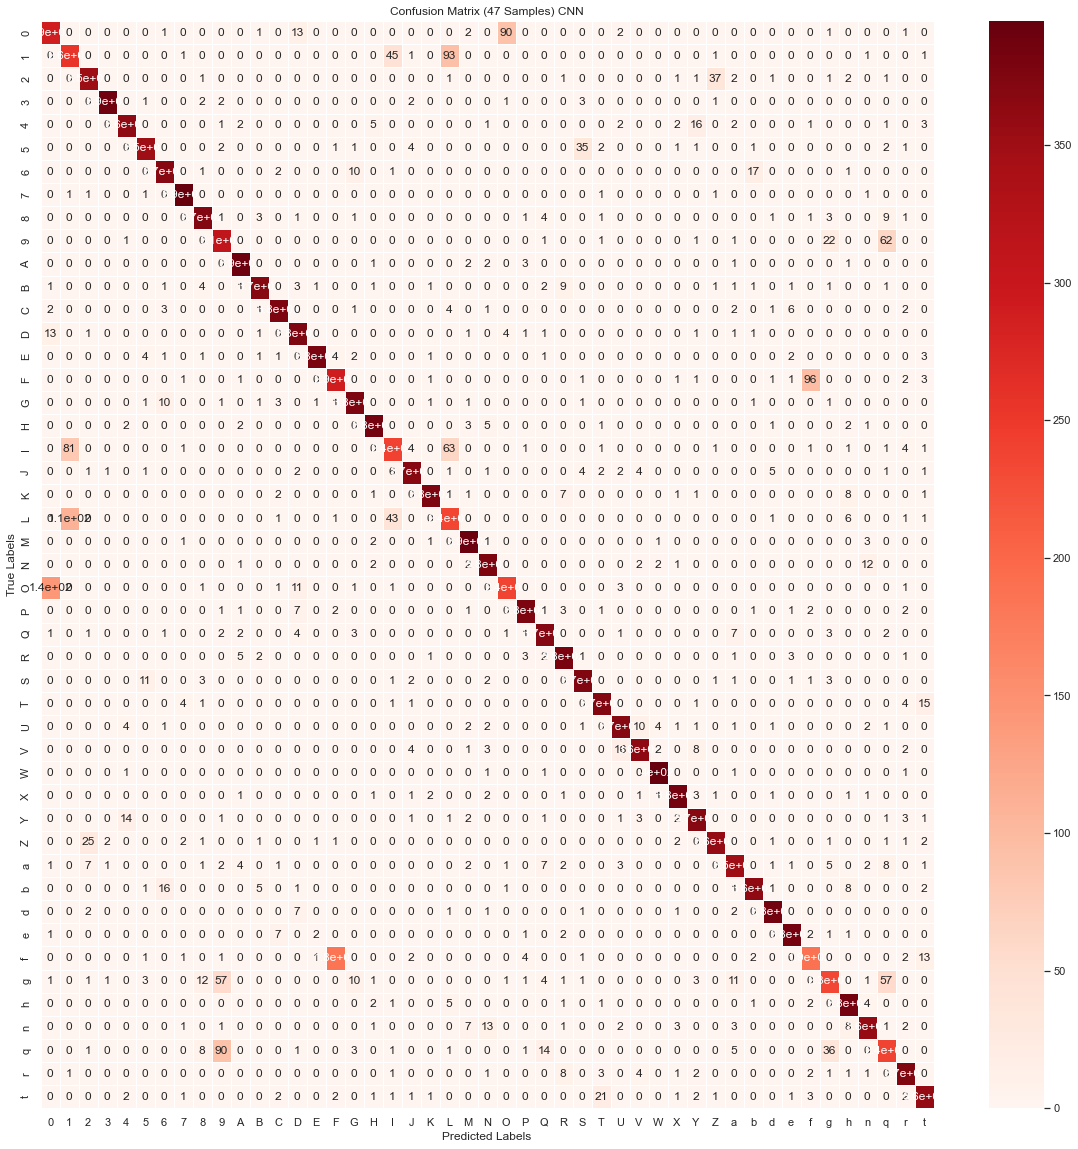

In [127]:
plot_cm_47(classes_test,classes_x,'Confusion Matrix (47 Samples) CNN')

### Evaluation Matrices CNN

In [111]:
Accuracy_CNN= accuracy_score(classes_test, classes_x)
Recall_CNN =  recall_score(classes_test, classes_x, average='macro')
Precision_CNN =  precision_score(classes_test, classes_x, average='macro')
F1Score_CNN = f1_score(classes_test, classes_x, average='macro') 

In [31]:
print("Accuracy:", accuracy_score(classes_test, classes_x))
print("Recall:", recall_score(classes_test, classes_x, average='macro'))
print("Precision:", precision_score(classes_test, classes_x, average='macro'))
print("F1 Score:", f1_score(classes_test, classes_x, average='macro'))


Accuracy: 0.8692553191489362
Recall: 0.8692553191489364
Precision: 0.8699661743180195
F1 Score: 0.8684489658164685


# Multi Layer Perceptron

#### Preprocessing for MLP model

In [40]:
X_valid_mlp, X_train_mlp = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0
y_valid_mlp, y_train_mlp = y_train_full[:5000], y_train_full[5000:]
X_test_mlp, y_test_mlp = test_data.iloc[:, 1:].to_numpy(
)/255.0, test_data.iloc[:, 0].to_numpy()


#### MLP model

In [71]:
def build_MLP_model(
    n_hidden=3,
    n_neurons=295,
    lr=3e-3,
    input_shape=(784,),
    activation='relu',
    optimizer=keras.optimizers.legacy.SGD(),
    num_op_classes=47,
    batch_norm=True,
    dropout=True,
    l1_reg=0.0,
    l2_reg=0.0,
    scheduler=None
):

    model = keras.models.Sequential()

    model.add(InputLayer(input_shape=input_shape))

    if batch_norm:
        model.add(BatchNormalization())

    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation=activation,
                  kernel_regularizer=l1(l1_reg), bias_regularizer=l2(l2_reg)))

        if batch_norm:
            model.add(BatchNormalization())

        if dropout:
            model.add(Dropout(0.25))

    model.add(Dense(num_op_classes, activation='softmax'))

    if scheduler == 'step':
        lr_scheduler = LearningRateScheduler(lambda epoch: lr*0.1**epoch)

    elif scheduler == 'stepDecay':
        lr_schedule = keras.optimizers.schedules.StepDecay(
            lr, decay_steps=10000, decay_rate=0.5)

    optimizer.lr = lr

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])

    return model


In [49]:
def grid_search(params, model):
    grid = GridSearchCV(estimator=model, param_grid=params, cv=3, verbose=2)
    grid_result = grid.fit(X_train_mlp, y_train_mlp)
    return grid_result.best_score_, grid_result.best_params_


In [50]:
keras_reg = KerasClassifier(
    build_MLP_model, epochs=5, batch_size=32, verbose=2)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_10232\1323568160.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasClassifier(


### Find best Optimizer

In [51]:
params = {
    'optimizer': [
        keras.optimizers.legacy.SGD(),
        keras.optimizers.legacy.Adam(),
        keras.optimizers.legacy.RMSprop()
    ]
}


In [52]:
best_score, best_params = grid_search(params, keras_reg)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/5
2246/2246 - 18s - loss: 2.4671 - accuracy: 0.3541 - 18s/epoch - 8ms/step
Epoch 2/5
2246/2246 - 16s - loss: 1.5772 - accuracy: 0.5450 - 16s/epoch - 7ms/step
Epoch 3/5
2246/2246 - 15s - loss: 1.3687 - accuracy: 0.5984 - 15s/epoch - 7ms/step
Epoch 4/5
2246/2246 - 14s - loss: 1.2471 - accuracy: 0.6288 - 14s/epoch - 6ms/step
Epoch 5/5
2246/2246 - 14s - loss: 1.1671 - accuracy: 0.6483 - 14s/epoch - 6ms/step
1123/1123 - 3s - loss: 0.8099 - accuracy: 0.7526 - 3s/epoch - 2ms/step
[CV] END optimizer=<keras.optimizers.legacy.gradient_descent.SGD object at 0x000001D995116220>; total time= 1.3min
Epoch 1/5
2246/2246 - 15s - loss: 2.4948 - accuracy: 0.3475 - 15s/epoch - 7ms/step
Epoch 2/5
2246/2246 - 14s - loss: 1.5886 - accuracy: 0.5425 - 14s/epoch - 6ms/step
Epoch 3/5
2246/2246 - 14s - loss: 1.3790 - accuracy: 0.5928 - 14s/epoch - 6ms/step
Epoch 4/5
2246/2246 - 15s - loss: 1.2508 - accuracy: 0.6264 - 15s/epoch - 7ms/step
Epoch 5/

In [53]:
print(best_score)
print(best_params)


0.8266975084940592
{'optimizer': <keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>}


### Batch Normalization and Dropout

In [54]:
params = {
    'optimizer': [best_params['optimizer']],
    'batch_norm': [True, False],
    'dropout': [True, False],
}


In [55]:
best_score, best_params = grid_search(params, keras_reg)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/5
2246/2246 - 21s - loss: 1.2775 - accuracy: 0.6219 - 21s/epoch - 9ms/step
Epoch 2/5
2246/2246 - 17s - loss: 0.8923 - accuracy: 0.7227 - 17s/epoch - 8ms/step
Epoch 3/5
2246/2246 - 16s - loss: 0.8006 - accuracy: 0.7471 - 16s/epoch - 7ms/step
Epoch 4/5
2246/2246 - 16s - loss: 0.7397 - accuracy: 0.7646 - 16s/epoch - 7ms/step
Epoch 5/5
2246/2246 - 17s - loss: 0.7007 - accuracy: 0.7773 - 17s/epoch - 7ms/step
1123/1123 - 3s - loss: 0.5089 - accuracy: 0.8367 - 3s/epoch - 3ms/step
[CV] END batch_norm=True, dropout=True, optimizer=<keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>; total time= 1.5min
Epoch 1/5
2246/2246 - 17s - loss: 1.2762 - accuracy: 0.6245 - 17s/epoch - 7ms/step
Epoch 2/5
2246/2246 - 16s - loss: 0.8967 - accuracy: 0.7221 - 16s/epoch - 7ms/step
Epoch 3/5
2246/2246 - 17s - loss: 0.7958 - accuracy: 0.7484 - 17s/epoch - 7ms/step
Epoch 4/5
2246/2246 - 16s - loss: 0.7399 - accuracy: 0.7655 - 16

In [56]:
print(best_score, best_params)


0.8373561898867289 {'batch_norm': True, 'dropout': False, 'optimizer': <keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>}


### Find best activation

In [57]:
params = {
    'optimizer': [best_params['optimizer']],
    'batch_norm': [best_params['batch_norm']],
    'dropout': [best_params['dropout']],
    'activation': ['relu', 'elu', 'sigmoid']
}


In [58]:
best_score, best_params = grid_search(params, keras_reg)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Epoch 1/5
2246/2246 - 17s - loss: 1.0262 - accuracy: 0.6855 - 17s/epoch - 7ms/step
Epoch 2/5
2246/2246 - 15s - loss: 0.6664 - accuracy: 0.7839 - 15s/epoch - 7ms/step
Epoch 3/5
2246/2246 - 15s - loss: 0.5715 - accuracy: 0.8096 - 15s/epoch - 7ms/step
Epoch 4/5
2246/2246 - 15s - loss: 0.5165 - accuracy: 0.8240 - 15s/epoch - 7ms/step
Epoch 5/5
2246/2246 - 15s - loss: 0.4780 - accuracy: 0.8344 - 15s/epoch - 7ms/step
1123/1123 - 3s - loss: 0.5062 - accuracy: 0.8410 - 3s/epoch - 3ms/step
[CV] END activation=relu, batch_norm=True, dropout=False, optimizer=<keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>; total time= 1.3min
Epoch 1/5
2246/2246 - 15s - loss: 1.0313 - accuracy: 0.6852 - 15s/epoch - 7ms/step
Epoch 2/5
2246/2246 - 14s - loss: 0.6611 - accuracy: 0.7852 - 14s/epoch - 6ms/step
Epoch 3/5
2246/2246 - 14s - loss: 0.5706 - accuracy: 0.8094 - 14s/epoch - 6ms/step
Epoch 4/5
2246/2246 - 14s - loss: 0.5161 - accu

In [59]:
print(best_score)
print(best_params)


0.8373469312985738
{'activation': 'elu', 'batch_norm': True, 'dropout': False, 'optimizer': <keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>}


### L1 and L2 Regularization

In [60]:
params = {
    'optimizer': [best_params['optimizer']],
    'batch_norm': [best_params['batch_norm']],
    'dropout': [best_params['dropout']],
    'activation': [best_params['activation']],
    'l1_reg': [0.0, 0.01],
    'l2_reg': [0.0, 0.01]
}


In [61]:
best_score, best_params = grid_search(params, keras_reg)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Epoch 1/5
2246/2246 - 17s - loss: 1.0229 - accuracy: 0.6859 - 17s/epoch - 8ms/step
Epoch 2/5
2246/2246 - 15s - loss: 0.6566 - accuracy: 0.7863 - 15s/epoch - 7ms/step
Epoch 3/5
2246/2246 - 15s - loss: 0.5657 - accuracy: 0.8126 - 15s/epoch - 7ms/step
Epoch 4/5
2246/2246 - 15s - loss: 0.5083 - accuracy: 0.8245 - 15s/epoch - 7ms/step
Epoch 5/5
2246/2246 - 15s - loss: 0.4797 - accuracy: 0.8350 - 15s/epoch - 7ms/step
1123/1123 - 3s - loss: 0.5168 - accuracy: 0.8330 - 3s/epoch - 3ms/step
[CV] END activation=elu, batch_norm=True, dropout=False, l1_reg=0.0, l2_reg=0.0, optimizer=<keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>; total time= 1.3min
Epoch 1/5
2246/2246 - 15s - loss: 1.0299 - accuracy: 0.6851 - 15s/epoch - 7ms/step
Epoch 2/5
2246/2246 - 14s - loss: 0.6566 - accuracy: 0.7861 - 14s/epoch - 6ms/step
Epoch 3/5
2246/2246 - 14s - loss: 0.5661 - accuracy: 0.8103 - 14s/epoch - 6ms/step
Epoch 4/5
2246/2246 - 1

In [62]:
print(best_score)
print(best_params)


0.8391465942064921
{'activation': 'elu', 'batch_norm': True, 'dropout': False, 'l1_reg': 0.0, 'l2_reg': 0.01, 'optimizer': <keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>}


### Find best Learning Rate

In [72]:
params = {
    'optimizer': [best_params['optimizer']],
    'batch_norm': [best_params['batch_norm']],
    'dropout': [best_params['dropout']],
    'activation': [best_params['activation']],
    'l1_reg': [best_params['l1_reg']],
    'l2_reg': [best_params['l2_reg']],
    'scheduler': ['stepDecay', 'step']
}


In [73]:
best_score, best_params = grid_search(params, keras_reg)


Fitting 3 folds for each of 2 candidates, totalling 6 fits
Epoch 1/5
2246/2246 - 29s - loss: 1.0203 - accuracy: 0.6868 - 29s/epoch - 13ms/step
Epoch 2/5
2246/2246 - 26s - loss: 0.6584 - accuracy: 0.7857 - 26s/epoch - 12ms/step
Epoch 3/5
2246/2246 - 30s - loss: 0.5630 - accuracy: 0.8115 - 30s/epoch - 13ms/step
Epoch 4/5
2246/2246 - 29s - loss: 0.5096 - accuracy: 0.8251 - 29s/epoch - 13ms/step
Epoch 5/5
2246/2246 - 27s - loss: 0.4730 - accuracy: 0.8369 - 27s/epoch - 12ms/step
1123/1123 - 5s - loss: 0.5384 - accuracy: 0.8319 - 5s/epoch - 5ms/step
[CV] END activation=elu, batch_norm=True, dropout=False, l1_reg=0.0, l2_reg=0.01, optimizer=<keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>, scheduler=stepDecay; total time= 2.4min
Epoch 1/5
2246/2246 - 26s - loss: 1.0316 - accuracy: 0.6843 - 26s/epoch - 12ms/step
Epoch 2/5
2246/2246 - 27s - loss: 0.6606 - accuracy: 0.7845 - 27s/epoch - 12ms/step
Epoch 3/5
2246/2246 - 27s - loss: 0.5656 - accuracy: 0.8103 - 27s/epoch - 12ms

In [78]:
print(best_score)
print(best_params)


0.8385435938835144
{'activation': 'elu', 'batch_norm': True, 'dropout': False, 'l1_reg': 0.0, 'l2_reg': 0.01, 'optimizer': <keras.optimizers.legacy.rmsprop.RMSprop object at 0x000001D995116FD0>, 'scheduler': 'step'}


### Train best model

In [74]:
best_model_mlp = build_MLP_model(
    activation=best_params['activation'],
    optimizer=best_params['optimizer'],
    batch_norm=best_params['batch_norm'],
    dropout=best_params['dropout'],
    l1_reg=best_params['l1_reg'],
    l2_reg=best_params['l2_reg'],
    scheduler=best_params['scheduler']
)
best_model_mlp.summary()


Model: "sequential_142"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_331 (Ba  (None, 784)              3136      
 tchNormalization)                                               
                                                                 
 dense_380 (Dense)           (None, 295)               231575    
                                                                 
 batch_normalization_332 (Ba  (None, 295)              1180      
 tchNormalization)                                               
                                                                 
 dense_381 (Dense)           (None, 295)               87320     
                                                                 
 batch_normalization_333 (Ba  (None, 295)              1180      
 tchNormalization)                                               
                                                    

In [76]:
start_time = time.time()
history = best_model_mlp.fit(X_train_mlp, y_train_mlp, epochs=30,
                             validation_data=(X_valid_mlp, y_valid_mlp))
end_time = time.time()
total_time1 = end_time - start_time
print(f"Total training time: {total_time1:.2f} seconds")


Epoch 1/30
3369/3369 [==============================] - 36s 11ms/step - loss: 0.3700 - accuracy: 0.8678 - val_loss: 0.4589 - val_accuracy: 0.8536
Epoch 2/30
3369/3369 [==============================] - 36s 11ms/step - loss: 0.3601 - accuracy: 0.8703 - val_loss: 0.4745 - val_accuracy: 0.8514
Epoch 3/30
3369/3369 [==============================] - 33s 10ms/step - loss: 0.3523 - accuracy: 0.8741 - val_loss: 0.4859 - val_accuracy: 0.8544
Epoch 4/30
3369/3369 [==============================] - 33s 10ms/step - loss: 0.3419 - accuracy: 0.8751 - val_loss: 0.4841 - val_accuracy: 0.8558
Epoch 5/30
3369/3369 [==============================] - 33s 10ms/step - loss: 0.3400 - accuracy: 0.8767 - val_loss: 0.4773 - val_accuracy: 0.8596
Epoch 6/30
3369/3369 [==============================] - 33s 10ms/step - loss: 0.3318 - accuracy: 0.8785 - val_loss: 0.4901 - val_accuracy: 0.8554
Epoch 7/30
3369/3369 [==============================] - 34s 10ms/step - loss: 0.3267 - accuracy: 0.8800 - val_loss: 0.4800 -

### Accuracy/Loss graph MLP

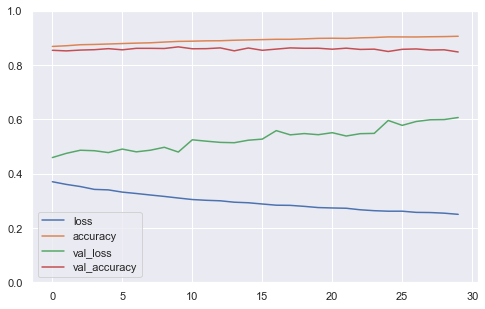

In [105]:

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()
best_model_mlp.save('my_MLP_model.h5')


### Test MLP

In [89]:
y_pred_mlp = best_model_mlp.predict(X_test_mlp)


588/588 [==============================] - 3s 5ms/step


In [90]:
classes_mlp = np.argmax(y_pred_mlp, axis=1)


### Prediction for top 6 samples in testing dataset with their images(MLP)

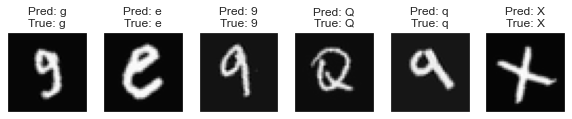

In [104]:

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 10), facecolor="white")
for i, ax in enumerate(axes.flat):
    # Display the image
    image = X_test[i]
    image = rotate(image, angle=240, reshape=True)
    ax.imshow(np.fliplr(image), cmap=plt.cm.gray)

    # Display the true label on top of the image

    ax.set_xticks([])
    ax.set_yticks([])

    # Display the predicted label on top of the true label
    ax.set_title(
        f"Pred: {chr(mappings[classes_mlp[i]][1])}\nTrue: {chr(mappings[classes_test[i]][1])}")
plt.show()

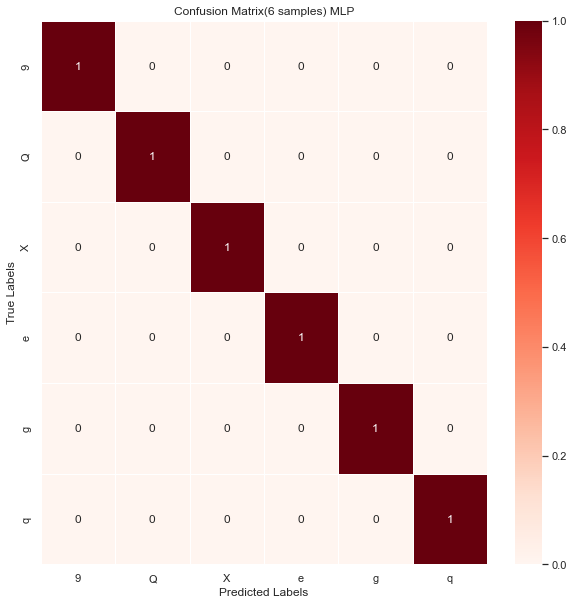

In [110]:
plot_cm(classes_test,classes_mlp,'Confusion Matrix(6 samples) MLP')


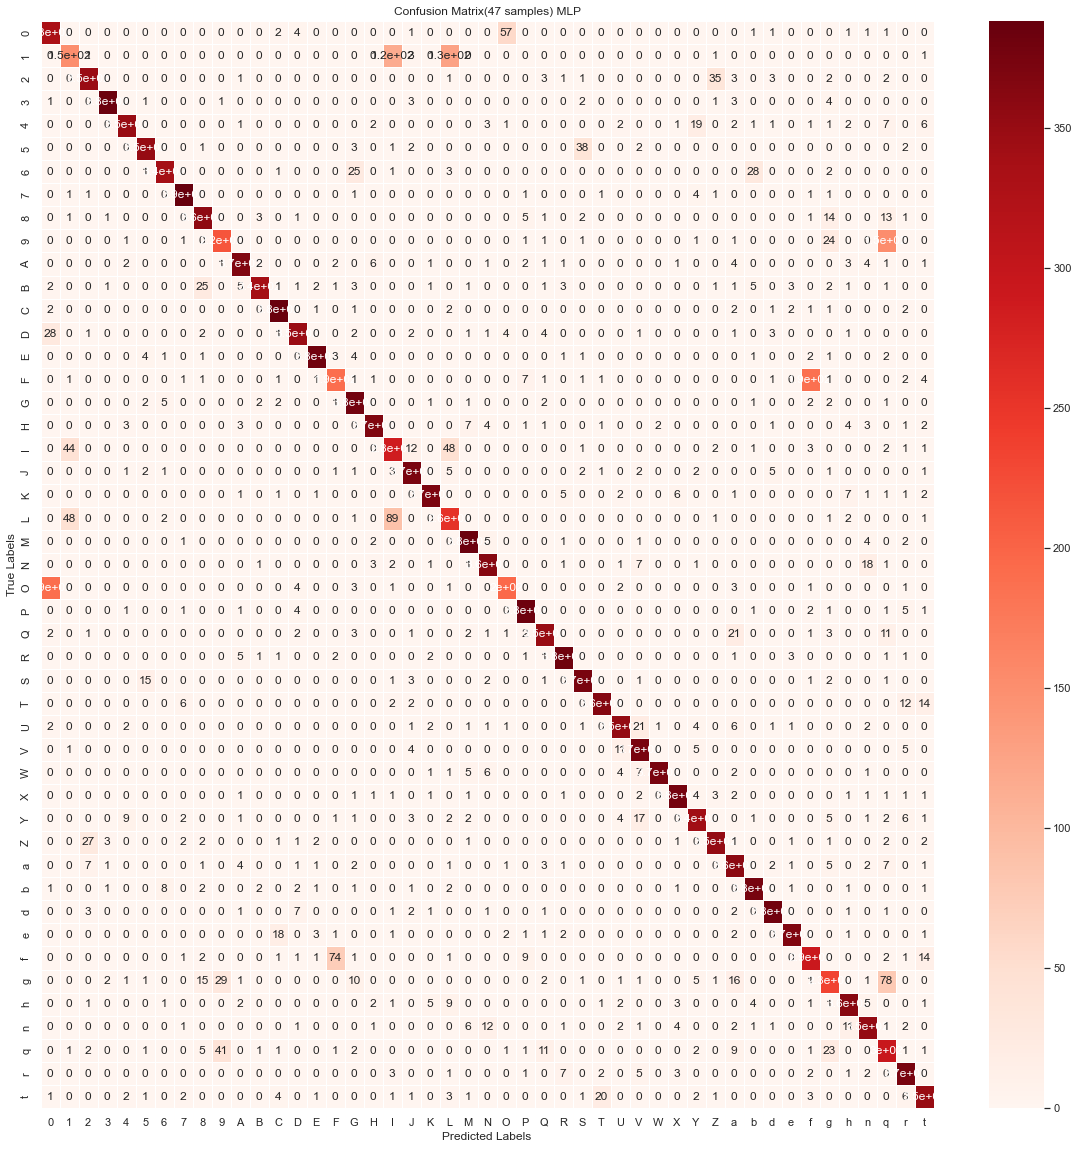

In [128]:
plot_cm_47(classes_test,classes_mlp,'Confusion Matrix(47 samples) MLP')

In [112]:
Accuracy_MLP= accuracy_score(classes_test, classes_mlp)
Recall_MLP =  recall_score(classes_test, classes_mlp, average='macro')
Precision_MLP =  precision_score(classes_test, classes_mlp, average='macro')
F1Score_MLP = f1_score(classes_test, classes_mlp, average='macro') 

In [103]:
print("Accuracy:", accuracy_score(classes_test, classes_mlp))
print("Recall:", recall_score(classes_test, classes_mlp, average='macro'))
print("Precision:", precision_score(classes_test, classes_mlp, average='macro'))
print("F1 Score:", f1_score(classes_test, classes_mlp, average='macro'))


Accuracy: 0.848404255319149
Recall: 0.848404255319149
Precision: 0.854564806937463
F1 Score: 0.8476031137053026


# Conclusion

### Final performance mterics of CNN and MLP

In [113]:

results = {
    'CNN': {'Accuracy': Accuracy_CNN, 'Precision': Precision_CNN, 'Recall': Recall_CNN, 'F1 Score': F1Score_CNN},
    'MLP': {'Accuracy': Accuracy_MLP, 'Precision': Precision_MLP, 'Recall': Recall_MLP, 'F1 Score': F1Score_MLP},
}

df = pd.DataFrame.from_dict(results, orient='index')

# display the DataFrame
df

,Accuracy,Precision,Recall,F1 Score
CNN,0.869255,0.869966,0.869255,0.868449
MLP,0.848404,0.854565,0.848404,0.847603


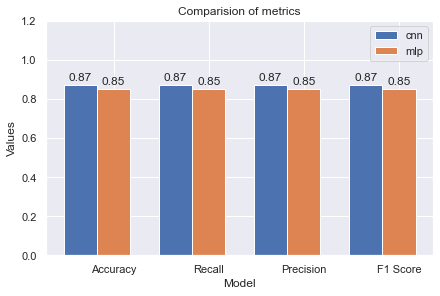

In [139]:
metrics = {
    'cnn': [Accuracy_CNN, Precision_CNN,Recall_CNN,F1Score_CNN],
    'mlp': [Accuracy_MLP, Precision_MLP,Recall_MLP,F1Score_MLP]
}

categories = ['Accuracy', 'Recall', 'Precision', 'F1 Score']

x = np.arange(len(categories))
bar_width = 0.35 # width of bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in metrics.items():
    # shift the bars
    offset = bar_width * multiplier
    rects = ax.bar(x + offset,[c.round(2) for c in measurement], bar_width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# add title, labels and custom x-axis tick labels
plt.xlabel('Model')
ax.set_xticks(x + bar_width, categories)
ax.set_ylim([0, 1.2])
plt.ylabel('Values')
plt.title('Comparision of metrics')
plt.legend(loc='upper right')
plt.show()